# Ichimoku Trading Strategy

Taken from https://www.pythonforfinance.net/2019/06/26/ichimoku-trading-strategy-with-python/
and https://www.pythonforfinance.net/2019/06/27/ichimoku-trading-strategy-with-python-part-2/
all code is from there with minor adjustments

In [7]:
import pandas as pd
from pandas_datareader import data, wb
import matplotlib as mpl
from mplfinance.original_flavor import candlestick_ohlc # we're using the old api
import matplotlib.dates as dates
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2019, 1, 27)
d = data.DataReader('F', 'yahoo', start, end)

In [8]:
# convert dates to integer values for use with matplotlib candlesticks which don't accept datetimes
d['Dates'] = dates.date2num(d.index)

Tenkan-Sen line, also called the Conversion Line, represents the midpoint of the last 9 candlesticks. It’s calculated by adding the highest high and the lowest low over the past nine periods and then dividing the result by two.

In [9]:
# (9 period high + 9 period low) / 2
nine_period_high = d['High'].rolling(window=9).max()
nine_period_low = d['Low'].rolling(window=9).min()
d['tenkan_sen'] = (nine_period_high + nine_period_low) / 2

Kijun-Sen line, also called the Base Line, represents the midpoint of the last 26 candlesticks. It’s calculated in a similar fashion to the Tenkan-Sen line however we use the last 26 candlesticks as mentioned rather than the last 9 – just add the highest high and the lowest low over the past 26 periods and then divide the result by two.

In [11]:
# (26 period high + 26 period low) / 2
twentysix_period_high = d['High'].rolling(window=26).max()
twentysix_period_low = d['Low'].rolling(window=26).min()
d['kijun_sen'] = (twentysix_period_high + twentysix_period_low) / 2

Chiou Span, also called the Lagging Span, lags behind the price (as the name suggests). The Lagging Span is plotted 26 periods back.

Senkou Span A, also called the Leading Span A, represents one of the two Cloud boundaries and it’s the midpoint between the Conversion Line (Tenkan-Sen) and the Base Line (Kijun-Sen). It’s calculated by adding the Tenkan-Sen line and the Kijun-Sen line together and dividng by 2. This value is plotted 26 periods into the future and it’s the faster Cloud boundary.

In [12]:
# (conversion line + base line) / 2
d['senkou_span_a'] = ((d['tenkan_sen'] + d['kijun_sen']) / 2).shift(26)

Senkou Span B, or the Leading Span B, represents the second Cloud boundaries and it’s the midpoint of the last 52 price bars. Add the highest high and the lowest low over the past 52 periods and then divide the result by two. This value is plotted 26 periods into the future and it’s the slower Cloud boundary. 

In [13]:
# (52-period high + 52-period low)/2))
period52_high = d['High'].rolling(window=52).max()
period52_low = d['Low'].rolling(window=52).min()
d['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(26)

There is an optional sixth element and that is the Chikou Span, representing the closing price and is plotted 26 days back. This line is used to show possible areas of support and resistance.

In [14]:
d['chikou_span'] = d['Close'].shift(-26)

Create a quick plot of the results:

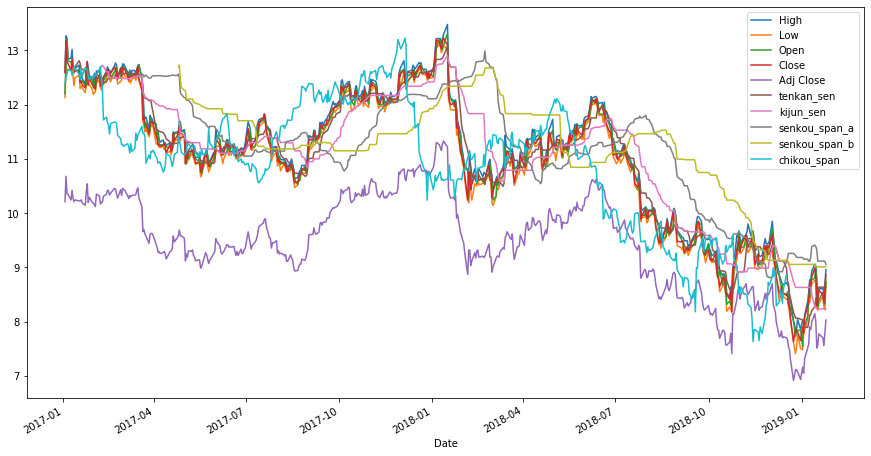

In [18]:
d.drop(['Dates', 'Volume'], axis=1).plot(figsize=(15,8))
plt.show()

Now we need to turn this into a OHLC chart to make it clearer

In [19]:
# Re-arrange data so that each row contains values of a day: 'Date','Open','High','Low','Close'.
# The 'Date' can't be a "datetime" object as the function wont accept them. That's why we converted 
# our 'Date' column into integer values using the "date2num" function earlier.
quotes = [tuple(x) for x in d[['Dates','Open','High','Low','Close']].values]

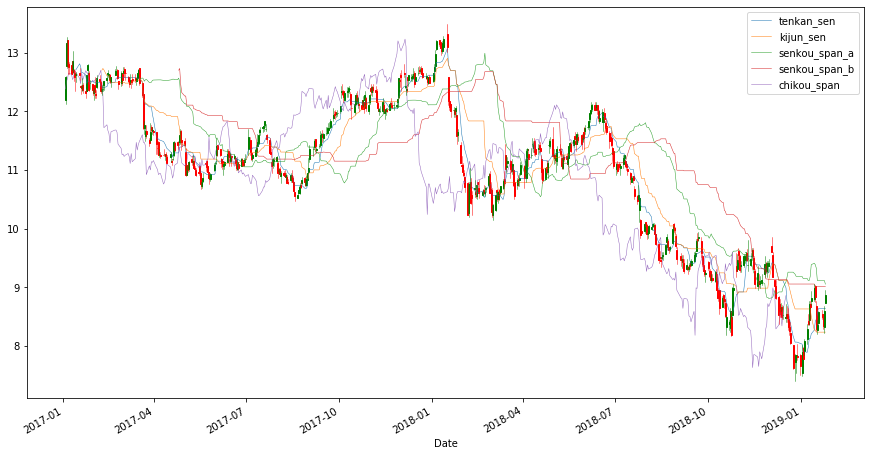

In [21]:
fig, ax = plt.subplots(figsize=(15,8))
d[['tenkan_sen','kijun_sen','senkou_span_a','senkou_span_b','chikou_span']].plot(ax=ax, linewidth=0.5)
candlestick_ohlc(ax, quotes, width=1.0, colorup='g', colordown='r');

In [25]:
# to make this graph easier to navigate we'll switch to plotly
#import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

In [26]:
init_notebook_mode(connected=True)

trace = go.Candlestick(x=d.index,
                      open=d['Open'],
                      high=d['High'],
                      low=d['Low'],
                      close=d['Close'])
data = [trace]
iplot(data, filename='simple_candlestick')

In [27]:
# set colours for up and down candles
INCREASING_COLOR = '#17BECF'
DECREASING_COLOR = '#7F7F7F'

# create list to hold dictionary with data for our first series to plot
# (which is the candlestick element itself)
data = [ dict(
    type = 'candlestick',
    open = d.Open,
    high = d.High,
    low = d.Low,
    close = d.Close,
    x = d.index,
    yaxis = 'y2',
    name = 'F',
    increasing = dict( line = dict( color = INCREASING_COLOR ) ),
    decreasing = dict( line = dict( color = DECREASING_COLOR ) ),
) ]
# Create empty dictionary for later use to hold settings and layout options
layout=dict()
# create our main chart "Figure" object which consists of data to plot and layout settings
fig = dict( data=data, layout=layout )
# Assign various seeting and choices - background colour, range selector etc
fig['layout']['plot_bgcolor'] = 'rgb(250, 250, 250)'
fig['layout']['xaxis'] = dict( rangeselector = dict( visible = True ) )
fig['layout']['yaxis'] = dict( domain = [0, 0.2], showticklabels = False )
fig['layout']['yaxis2'] = dict( domain = [0.2, 0.8] )
fig['layout']['legend'] = dict( orientation = 'h', y=0.9, x=0.3, yanchor='bottom' )
fig['layout']['margin'] = dict( t=40, b=40, r=40, l=40 )
# Populate the "rangeselector" object with necessary settings
rangeselector=dict(
    visible = True,
    x = 0, y = 0.9,
    bgcolor = 'rgba(150, 200, 250, 0.4)',
    font = dict( size = 13 ),
    buttons=list([
        dict(count=1,
             label='reset',
             step='all'),
        dict(count=1,
             label='1yr',
             step='year',
             stepmode='backward'),
        dict(count=3,
            label='3 mo',
            step='month',
            stepmode='backward'),
        dict(count=1,
            label='1 mo',
            step='month',
            stepmode='backward'),
        dict(step='all')
    ]))
    
fig['layout']['xaxis']['rangeselector'] = rangeselector
# Append the Ichimoku elements to the plot
fig['data'].append( dict( x=d['tenkan_sen'].index, y=d['tenkan_sen'], type='scatter', mode='lines', 
                         line = dict( width = 1 ),
                         marker = dict( color = '#33BDFF' ),
                         yaxis = 'y2', name='tenkan_sen' ) )
fig['data'].append( dict( x=d['kijun_sen'].index, y=d['kijun_sen'], type='scatter', mode='lines', 
                         line = dict( width = 1 ),
                         marker = dict( color = '#F1F316' ),
                         yaxis = 'y2', name='kijun_sen' ) )
fig['data'].append( dict( x=d['senkou_span_a'].index, y=d['senkou_span_a'], type='scatter', mode='lines', 
                         line = dict( width = 1 ), 
                         marker = dict( color = '#228B22' ),
                         yaxis = 'y2', name='senkou_span_a' ) )
fig['data'].append( dict( x=d['senkou_span_b'].index, y=d['senkou_span_b'], type='scatter', mode='lines', 
                         line = dict( width = 1 ),fill='tonexty',
                         marker = dict( color = '#FF3342' ),
                         yaxis = 'y2', name='senkou_span_b' ) )
fig['data'].append( dict( x=d['chikou_span'].index, y=d['chikou_span'], type='scatter', mode='lines', 
                         line = dict( width = 1 ),
                         marker = dict( color = '#D105F5' ),
                         yaxis = 'y2', name='chikou_span' ) )
# Set colour list for candlesticks
colors = []
for i in range(len(d.Close)):
    if i != 0:
        if d.Close[i] > d.Close[i-1]:
            colors.append(INCREASING_COLOR)
        else:
            colors.append(DECREASING_COLOR)
    else:
        colors.append(DECREASING_COLOR)
        
iplot( fig, filename = 'candlestick-ichimoku' )